In [1]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn import metrics
from sklearn.model_selection import cross_val_score

In [2]:
vb = pd.read_csv("../data/vb_data_categZone.csv")
vbn = pd.read_csv("../data/vb_data_numZone.csv")
print(len(vb), 'lines loaded')

96795 lines loaded


In [12]:
#categorical version
vb.head()

,Season,GameID,PlayerTeam,PlayerName,RewardValue,RewardDistance,SetNumber,ScoreMax,ScoreDiff,ActionHome9,...,ActionEndZone1,ActionSpeed1,ActionOutcome1,ActionHome0,ActionAway0,ActionType0,ActionStartZone0,ActionEndZone0,ActionSpeed0,ActionOutcome0
0,2019/2020,Canada West MVB<25>: UBCO - UBC,UBC,Jordan Deshane,-1,3,1,0,0,0,...,-1,0,0,0,1,S,Z1,Z1,-1,-
1,2019/2020,Canada West MVB<25>: UBCO - UBC,UBCO,Noah Campbell,-1,2,1,0,0,0,...,Z1,-1,-,1,0,R,Z1,Z2D,-1,+
2,2019/2020,Canada West MVB<25>: UBCO - UBC,UBCO,Morgan Nichols,-1,1,1,0,0,0,...,Z2D,-1,+,1,0,E,Z2D,Z4C,1,#
3,2019/2020,Canada West MVB<25>: UBCO - UBC,UBCO,Denham O'Reilly,-1,0,1,0,0,0,...,Z4C,1,#,1,0,A,Z4,Z7,1,=
4,2019/2020,Canada West MVB<25>: UBCO - UBC,UBC,Jordan Deshane,-1,5,1,1,1,0,...,-1,0,0,0,1,S,Z1,Z6,-1,-


In [13]:
#numerical version
vbn.head()

,Season,GameID,PlayerTeam,PlayerName,RewardValue,RewardDistance,SetNumber,ScoreMax,ScoreDiff,ActionHome9,...,ActionOutcome1,ActionHome0,ActionAway0,ActionType0,ActionStartX0,ActionStartY0,ActionEndX0,ActionEndY0,ActionSpeed0,ActionOutcome0
0,2019/2020,Canada West MVB<25>: UBCO - UBC,UBC,Jordan Deshane,-1,3,1,0,0,0,...,0,0,1,S,1.50,7.50,1.50,7.50,-1,-
1,2019/2020,Canada West MVB<25>: UBCO - UBC,UBCO,Noah Campbell,-1,2,1,0,0,0,...,-,1,0,R,1.50,7.50,2.25,2.25,-1,+
2,2019/2020,Canada West MVB<25>: UBCO - UBC,UBCO,Morgan Nichols,-1,1,1,0,0,0,...,+,1,0,E,2.25,2.25,8.25,0.75,1,#
3,2019/2020,Canada West MVB<25>: UBCO - UBC,UBCO,Denham O'Reilly,-1,0,1,0,0,0,...,#,1,0,A,7.50,1.50,7.50,4.50,1,=
4,2019/2020,Canada West MVB<25>: UBCO - UBC,UBC,Jordan Deshane,-1,5,1,1,1,0,...,0,0,1,S,1.50,7.50,4.50,7.50,-1,-


In [14]:
# For how many lines do we already know the result beacuse A#, S#, B# or error?
i = 0
for index, row in vb.iterrows():
    increase = 0
    s = row['ActionType0']+row['ActionOutcome0']+row['ActionType1']+row['ActionOutcome1']+row['ActionType2']+row['ActionOutcome2']+row['ActionType3']+row['ActionOutcome3']+row['ActionType4']+row['ActionOutcome4']+row['ActionType5']+row['ActionOutcome5']+row['ActionType6']+row['ActionOutcome6']+row['ActionType7']+row['ActionOutcome7']+row['ActionType8']+row['ActionOutcome8']+row['ActionType9']+row['ActionOutcome9']

    if 'A#' in s:
        increase = 1
    if 'B#' in s:
        increase = 1
    if 'S#' in s:
        increase = 1 
    if '=' in s:
        increase = 1
    
    i = i+increase
    
print(i/len(vb))

0.3199442119944212


In [3]:
X = vb.drop(['Season', 'GameID', 'PlayerTeam', 'PlayerName', 'RewardDistance', 'RewardValue'], axis=1)
Xn = vbn.drop(['Season', 'GameID', 'PlayerTeam', 'PlayerName', 'RewardDistance', 'RewardValue'], axis=1)
#zone_cols = [col for col in list(X.columns) if 'Start' in col or 'End' in col or 'Zone' in col]
#outcome_cols = [col for col in list(X.columns) if 'Outcome' in col]

#experiment without zones
#X = X.drop(outcome_cols, axis=1)

print(len(X.columns), 'columns in categorical dataframe')
print(len(Xn.columns), 'columns in numerical dataframe')

cols = [col for col in list(X.columns) if X[col].dtype == 'object']
X = pd.get_dummies(data=X, columns = cols)
y = vb.RewardValue

cols = [col for col in list(Xn.columns) if Xn[col].dtype == 'object']
Xn = pd.get_dummies(data=Xn, columns = cols)
yn = vbn.RewardValue

print(len(X.columns), 'columns in categorical dataframe after dummies')
print(len(Xn.columns), 'columns in numerical dataframe after dummies')

73 columns in categorical dataframe
93 columns in numerical dataframe
913 columns in categorical dataframe after dummies
204 columns in numerical dataframe after dummies


### Categorical data tests

In [ ]:
depth = []
for i in range(200,3000,500):
    print('Checking min_samples_split =', i)
    clf = DecisionTreeClassifier(min_samples_split=i)
    # Perform 5-fold cross validation 
    scores = cross_val_score(estimator=clf, X=X, y=y, cv=5, n_jobs=4)
    depth.append((i,scores.mean()))
    print('Mean cross validation accuracy:', scores.mean())
#print(depth)

In [15]:
depth = []
for i in range(9,15):
    print('Checking max_depth =', i)
    clf = DecisionTreeClassifier(max_depth=i, min_samples_split=200)
    # Perform 5-fold cross validation
    scores = cross_val_score(estimator=clf, X=X, y=y, cv=5, n_jobs=4)
    depth.append((i,scores.mean()))
    print('Mean cross validation accuracy:', scores.mean())
#print(depth)

Checking max_depth = 9
Mean cross validation accuracy: 0.7365773025466191
Checking max_depth = 10
Mean cross validation accuracy: 0.7404514696007025
Checking max_depth = 11
Mean cross validation accuracy: 0.7418771630766052
Checking max_depth = 12
Mean cross validation accuracy: 0.7424763675809702
Checking max_depth = 13
Mean cross validation accuracy: 0.7421044475437781
Checking max_depth = 14
Mean cross validation accuracy: 0.7415052430394132


In [10]:
import time
t = time.time()

# Create Decision Tree classifer object
clf = DecisionTreeClassifier(max_depth=12, min_samples_split=200)
# Train Decision Tree Classifer
clf = clf.fit(X,y)
y_pred = clf.predict(X)
print("Accuracy:", metrics.accuracy_score(y, y_pred))
print('Elapsed: %.2f seconds' % (time.time() - t))

Accuracy: 0.7520223152022315
Elapsed: 7.38 seconds


array([0.34505159, 0.28571429, 0.42105263, ..., 0.23800905, 0.22222222,
       1.        ])

In [8]:
cond = (y != y_pred)
vb_wrong = vb[cond]
vb_wrong[['ActionType0','ActionOutcome0']].head(30)
print(len(vb_wrong), 'wrong predictions')

63860 wrong predictions


In [14]:
# compute probabilities
y_prob = clf.predict_proba(X)

print('Total mean probability:', np.mean(y_prob[:,0]))

print('\nHome # Receive by score:')
for score in range(5,26,5): #['Z3','Z4','Z2','Z9','Z8']:
    cond = (vb['ActionType0']=='R') & (vb['ActionOutcome0']=='#') & (vb['ActionHome0']==1) & (vb['ScoreMax']<score) & (vb['ScoreMax']>=score-5)
    y_pred = clf.predict(X[cond])
    homepoints = len(y_pred[y_pred==1])
    totalpoints = len(X[cond])
    #print(score, np.mean(y_prob[cond,1], axis=0), 0.5+0.5*np.mean(vb.RewardValue[cond], axis=0))
    print('%s: avg probability %.1f%% (actual %.1f%%), %.1f%% classified as home point ' % \
          (score, 100*np.mean(y_prob[cond,1], axis=0), 50+50*np.mean(vb.RewardValue[cond], axis=0),\
           100*homepoints/totalpoints))

    print('\nHome Set by zone:')
for zone in ['3A','3B','3C','3D','2A','2B','2C','2D','4A','4B','4C','4D','9B','9C','8B','8C','7B','7C']:
    cond = (vb['ActionType0']=='E') & (vb['ActionHome0']==1) & (vb['ActionStartZone0']=='Z'+zone)
    y_pred = clf.predict(X[cond])
    homepoints = len(y_pred[y_pred==1])
    totalpoints = len(X[cond])
    #print(score, np.mean(y_prob[cond,1], axis=0), 0.5+0.5*np.mean(vb.RewardValue[cond], axis=0))
    print('%s: avg probability %.1f%% (actual %.1f%% out of %d), %.1f%% classified as home point ' % \
          (zone, 100*np.mean(y_prob[cond,1], axis=0), 50+50*np.mean(vb.RewardValue[cond], axis=0),\
           len(y_pred), 100*homepoints/totalpoints)) 
    
print('\nPlayers average point probability (as home only):')
for name in ['Jordan Deshane','Ben Hooker','Matt Neaves','Danny Aspenlieder','Coltyn Liu']:
    cond = (vb['PlayerName']==name) & (vb['ActionHome0']==1)
    print('%s: %.1f%% (actual %.1f%%)' % (name, 100*np.mean(y_prob[cond,1], axis=0), 50+50*np.mean(vb.RewardValue[cond], axis=0)))
    
    
print('\nHome Serve:')
for outcome in ['=','-','!','+','#']:
    cond = (vb['ActionType0']=='S') & (vb['ActionHome0']==1) & (vb['ActionOutcome0']==outcome)
    y_pred = clf.predict(X[cond])
    awaypoints = len(y_pred[y_pred==-1])
    totalpoints = len(X[cond])
    print('%s: avg probability %.1f%% (actual %.1f%%), %.1f%% classified as away point ' % \
          (outcome, 100*np.mean(y_prob[cond,1], axis=0), 50+50*np.mean(vb.RewardValue[cond], axis=0),\
           100*awaypoints/totalpoints))
    
print('\nAway Receive:')
for outcome in ['=','-','!','+','#']:
    cond = (vb['ActionType0']=='R') & (vb['ActionAway0']==1) & (vb['ActionOutcome0']==outcome)
    y_pred = clf.predict(X[cond])
    awaypoints = len(y_pred[y_pred==-1])
    totalpoints = len(X[cond])
    print('%s: avg probability %.1f%% (actual %.1f%%), %.1f%% classified as away point ' % \
          (outcome, 100*np.mean(y_prob[cond,1], axis=0), 50+50*np.mean(vb.RewardValue[cond], axis=0),\
           100*awaypoints/totalpoints))

Total mean probability: 0.4810372436592799

Home # Receive by score:
5: avg probability 71.6% (actual 69.7%), 100.0% classified as home point 

Home Set by zone:
10: avg probability 70.0% (actual 71.5%), 99.1% classified as home point 

Home Set by zone:
15: avg probability 70.9% (actual 69.9%), 99.5% classified as home point 

Home Set by zone:
20: avg probability 71.6% (actual 73.5%), 99.7% classified as home point 

Home Set by zone:
25: avg probability 72.9% (actual 71.3%), 100.0% classified as home point 

Home Set by zone:
3A: avg probability 65.3% (actual 65.5% out of 1093), 98.4% classified as home point 
3B: avg probability 70.8% (actual 71.3% out of 1378), 99.0% classified as home point 
3C: avg probability 68.8% (actual 68.8% out of 494), 99.4% classified as home point 
3D: avg probability 63.6% (actual 61.3% out of 429), 86.5% classified as home point 
2A: avg probability 63.5% (actual 63.8% out of 152), 99.3% classified as home point 
2B: avg probability 64.8% (actual 57.6

<BarContainer object of 31 artists>

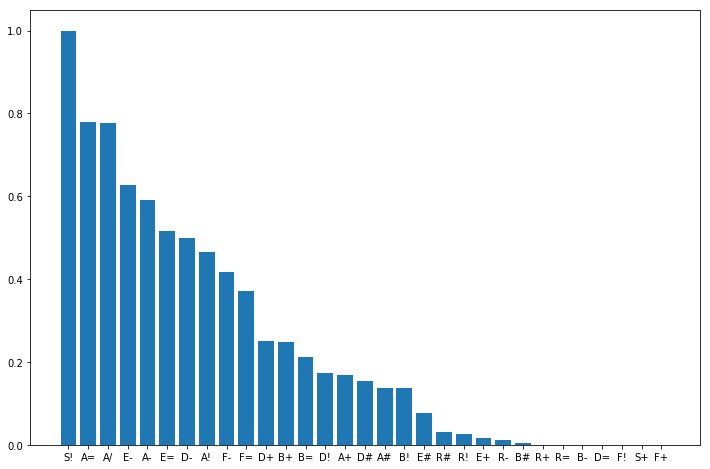

In [60]:
#check how often predictions change from beginning of rally
y_pred = clf.predict(X)
counts_flip = {}
counts_stay = {}
for i in range(1,len(vb)):
    if (vb.ScoreMax[i] == vb.ScoreMax[i-1]) & (vb.ScoreDiff[i] == vb.ScoreDiff[i-1]):
        action_string = (vb.ActionType0[i]+vb.ActionOutcome0[i])
        if not(action_string in counts_flip.keys()):
            counts_flip[action_string] = 0
        if not(action_string in counts_stay.keys()):
            counts_stay[action_string] = 0

        if y_pred[i] != y_pred[i-1]:
            counts_flip[action_string] = counts_flip[action_string] + 1
        else:
            counts_stay[action_string] = counts_stay[action_string] + 1

import matplotlib.pyplot as plt
plt.figure(figsize=(12,8))
count_ratios = {k: counts_flip[k]/(counts_flip[k]+counts_stay[k]) for k in counts_flip.keys()}
srt_counts = {k: v for k, v in sorted(count_ratios.items(), key=lambda item: item[1], reverse=True)}
plt.bar(srt_counts.keys(), srt_counts.values())

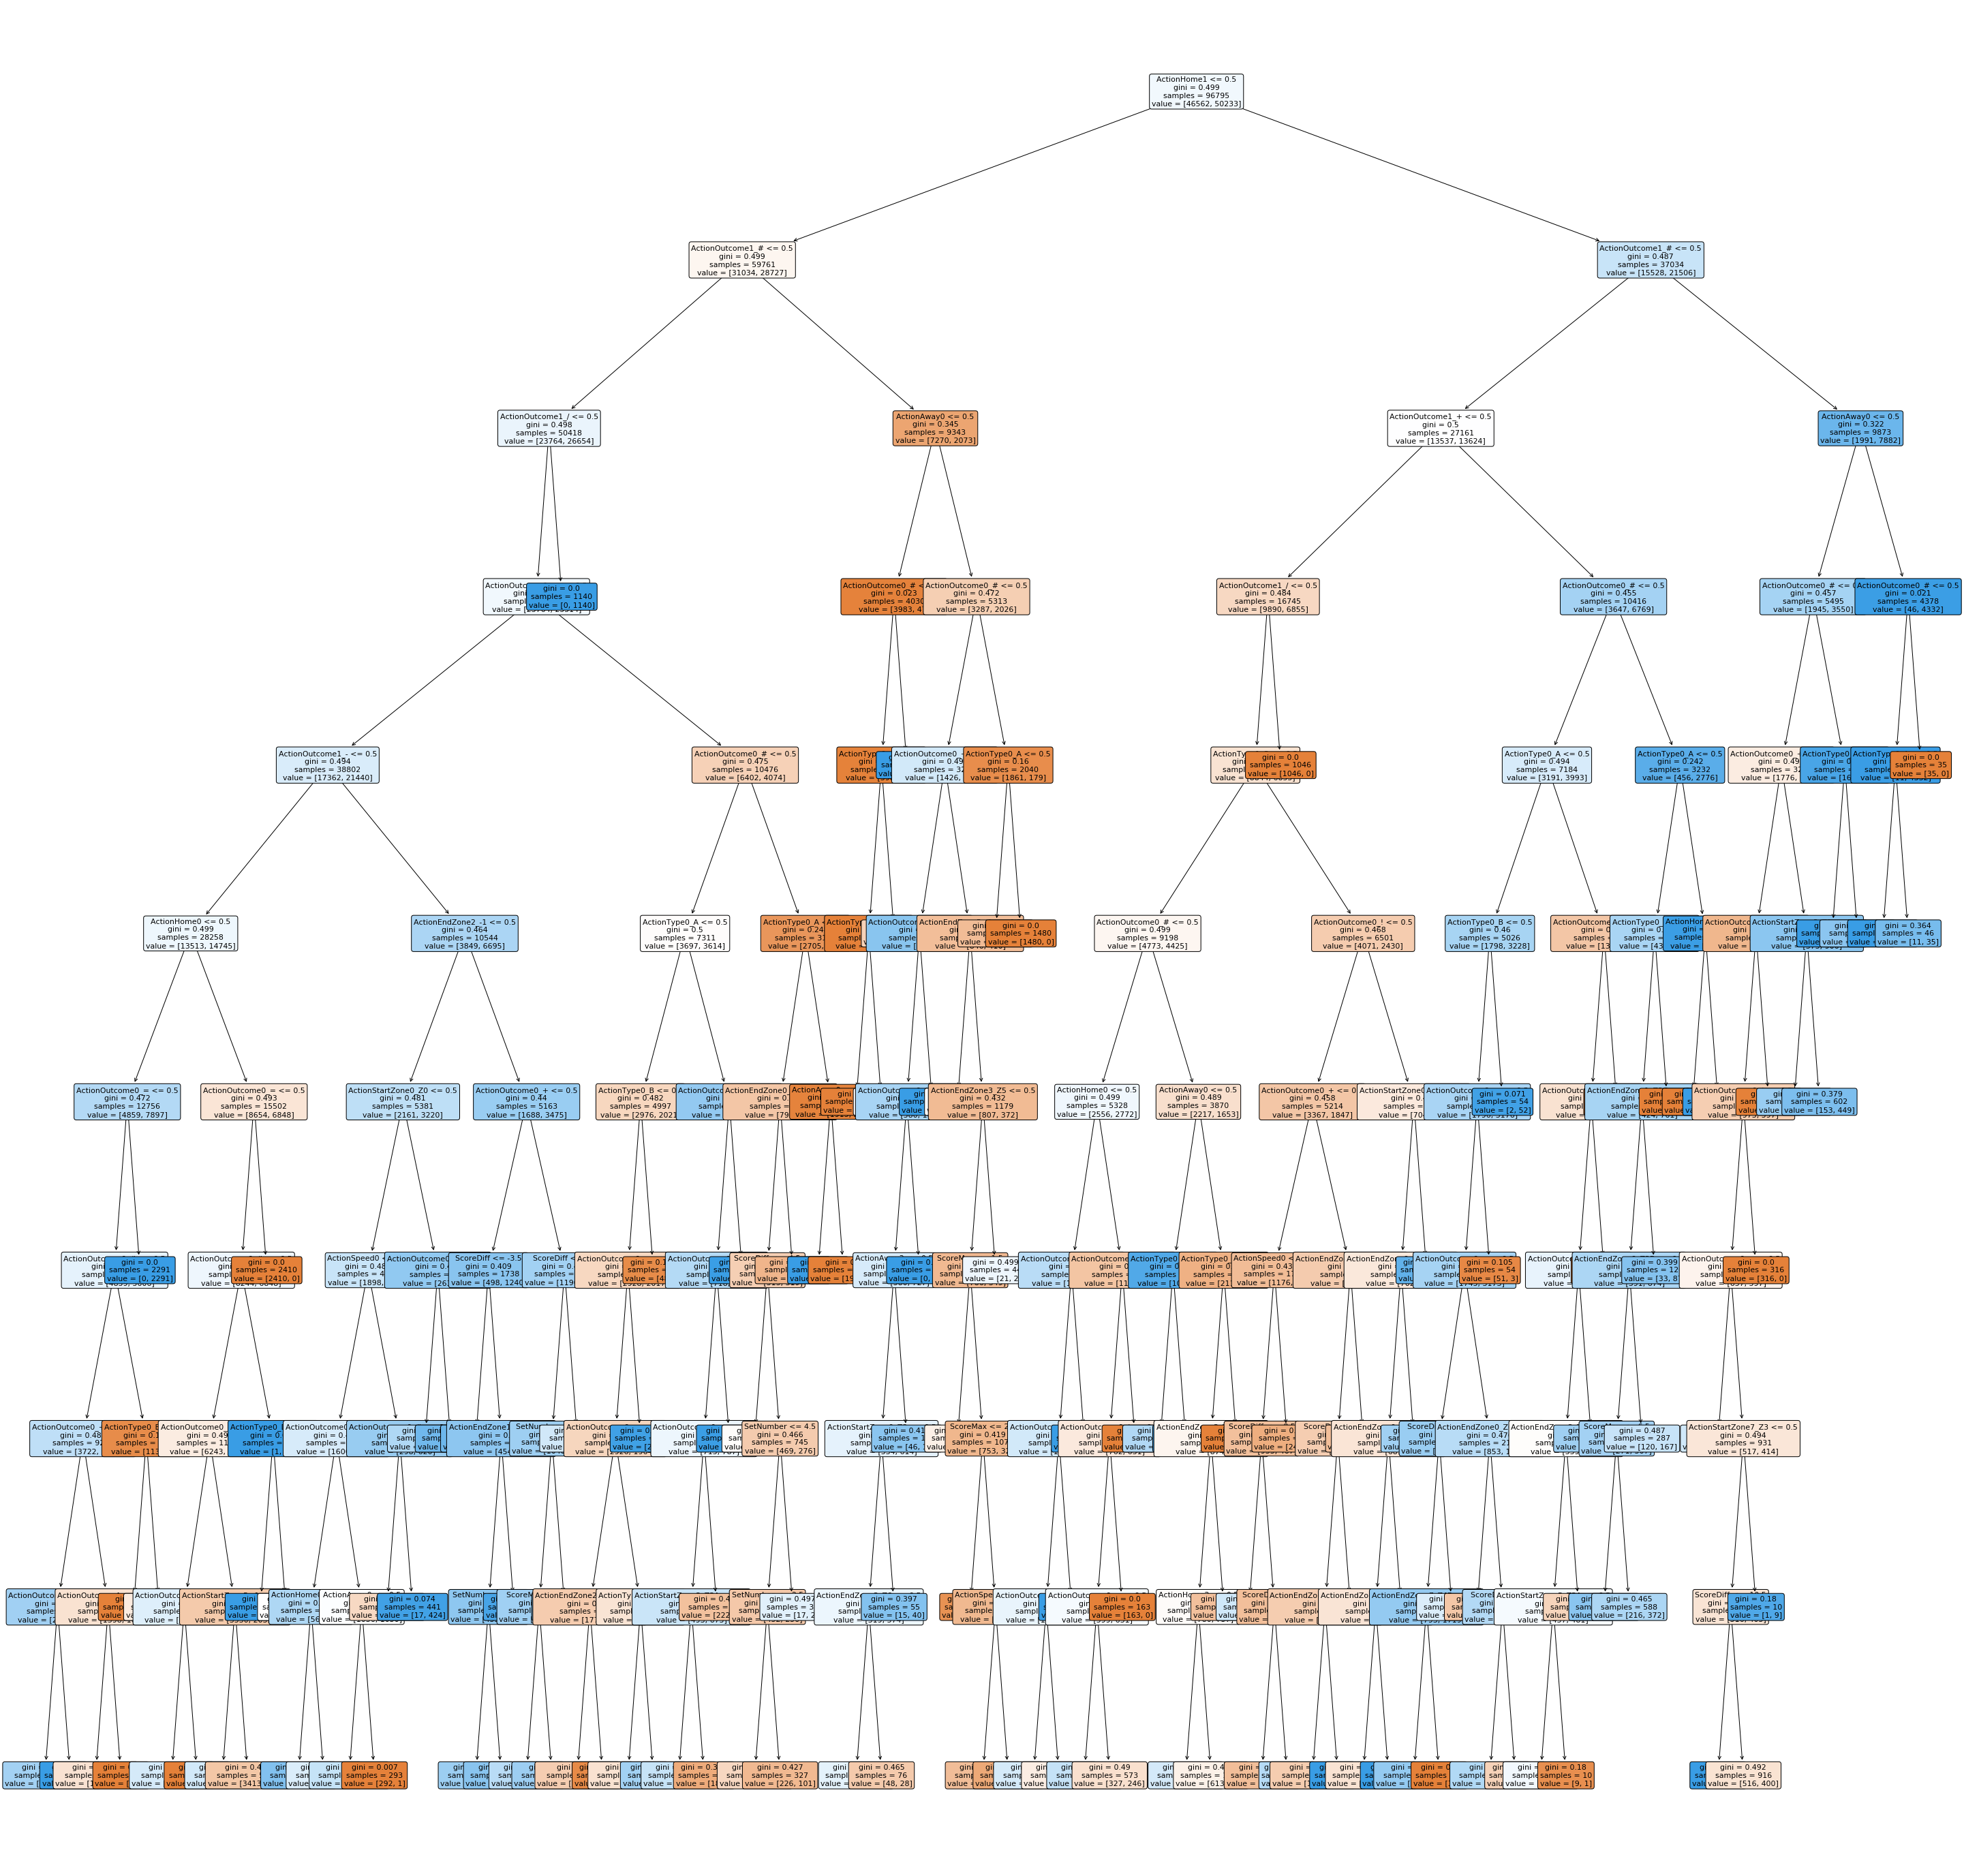

In [21]:
from sklearn.tree import plot_tree

plt.figure(figsize=(50,50))
a = plot_tree(clf, feature_names=X.columns, filled=True, rounded=True, fontsize=11)

### Numerical data tests

In [33]:
depth = []
for i in range(200,3000,500):
    print('Checking min_samples_split =', i)
    clf = DecisionTreeClassifier(min_samples_split=i)
    # Perform 5-fold cross validation 
    scores = cross_val_score(estimator=clf, X=Xn, y=yn, cv=5, n_jobs=4)
    depth.append((i,scores.mean()))
    print('Mean cross validation accuracy:', scores.mean())
#print(depth)

Checking min_samples_split = 200
Mean cross validation accuracy: 0.730481946381528
Checking min_samples_split = 700
Mean cross validation accuracy: 0.7369285603595228
Checking min_samples_split = 1200
Mean cross validation accuracy: 0.7378686915646469
Checking min_samples_split = 1700
Mean cross validation accuracy: 0.733973862286275
Checking min_samples_split = 2200
Mean cross validation accuracy: 0.7336639289219485
Checking min_samples_split = 2700
Mean cross validation accuracy: 0.7210806343302856


In [42]:
depth = []
for i in range(9,15):
    print('Checking max_depth =', i)
    clf = DecisionTreeClassifier(max_depth=i, min_samples_split=200)
    # Perform 5-fold cross validation 
    scores = cross_val_score(estimator=clf, X=Xn, y=yn, cv=5, n_jobs=4)
    depth.append((i,scores.mean()))
    print('Mean cross validation accuracy:', scores.mean())
#print(depth)

Checking max_depth = 9
Mean cross validation accuracy: 0.7373934604060126
Checking max_depth = 10
Mean cross validation accuracy: 0.7411746474507981
Checking max_depth = 11
Mean cross validation accuracy: 0.7406270985071542
Checking max_depth = 12
Mean cross validation accuracy: 0.7404927940492794
Checking max_depth = 13
Mean cross validation accuracy: 0.7396766361898859
Checking max_depth = 14
Mean cross validation accuracy: 0.7389637894519344


In [4]:
# Create Decision Tree classifer object
clfn = DecisionTreeClassifier(max_depth = 10, min_samples_split=200)
# Train Decision Tree Classifer
clfn = clfn.fit(Xn,yn)
yn_pred = clfn.predict(Xn)
print("Accuracy:", metrics.accuracy_score(yn, yn_pred))

Accuracy: 0.7467741102329666


In [8]:
import pickle
y_prob = clfn.predict_proba(Xn)
pickle.dump(y_prob, open('../output/y_probabilities_tree.pkl', 'wb'))

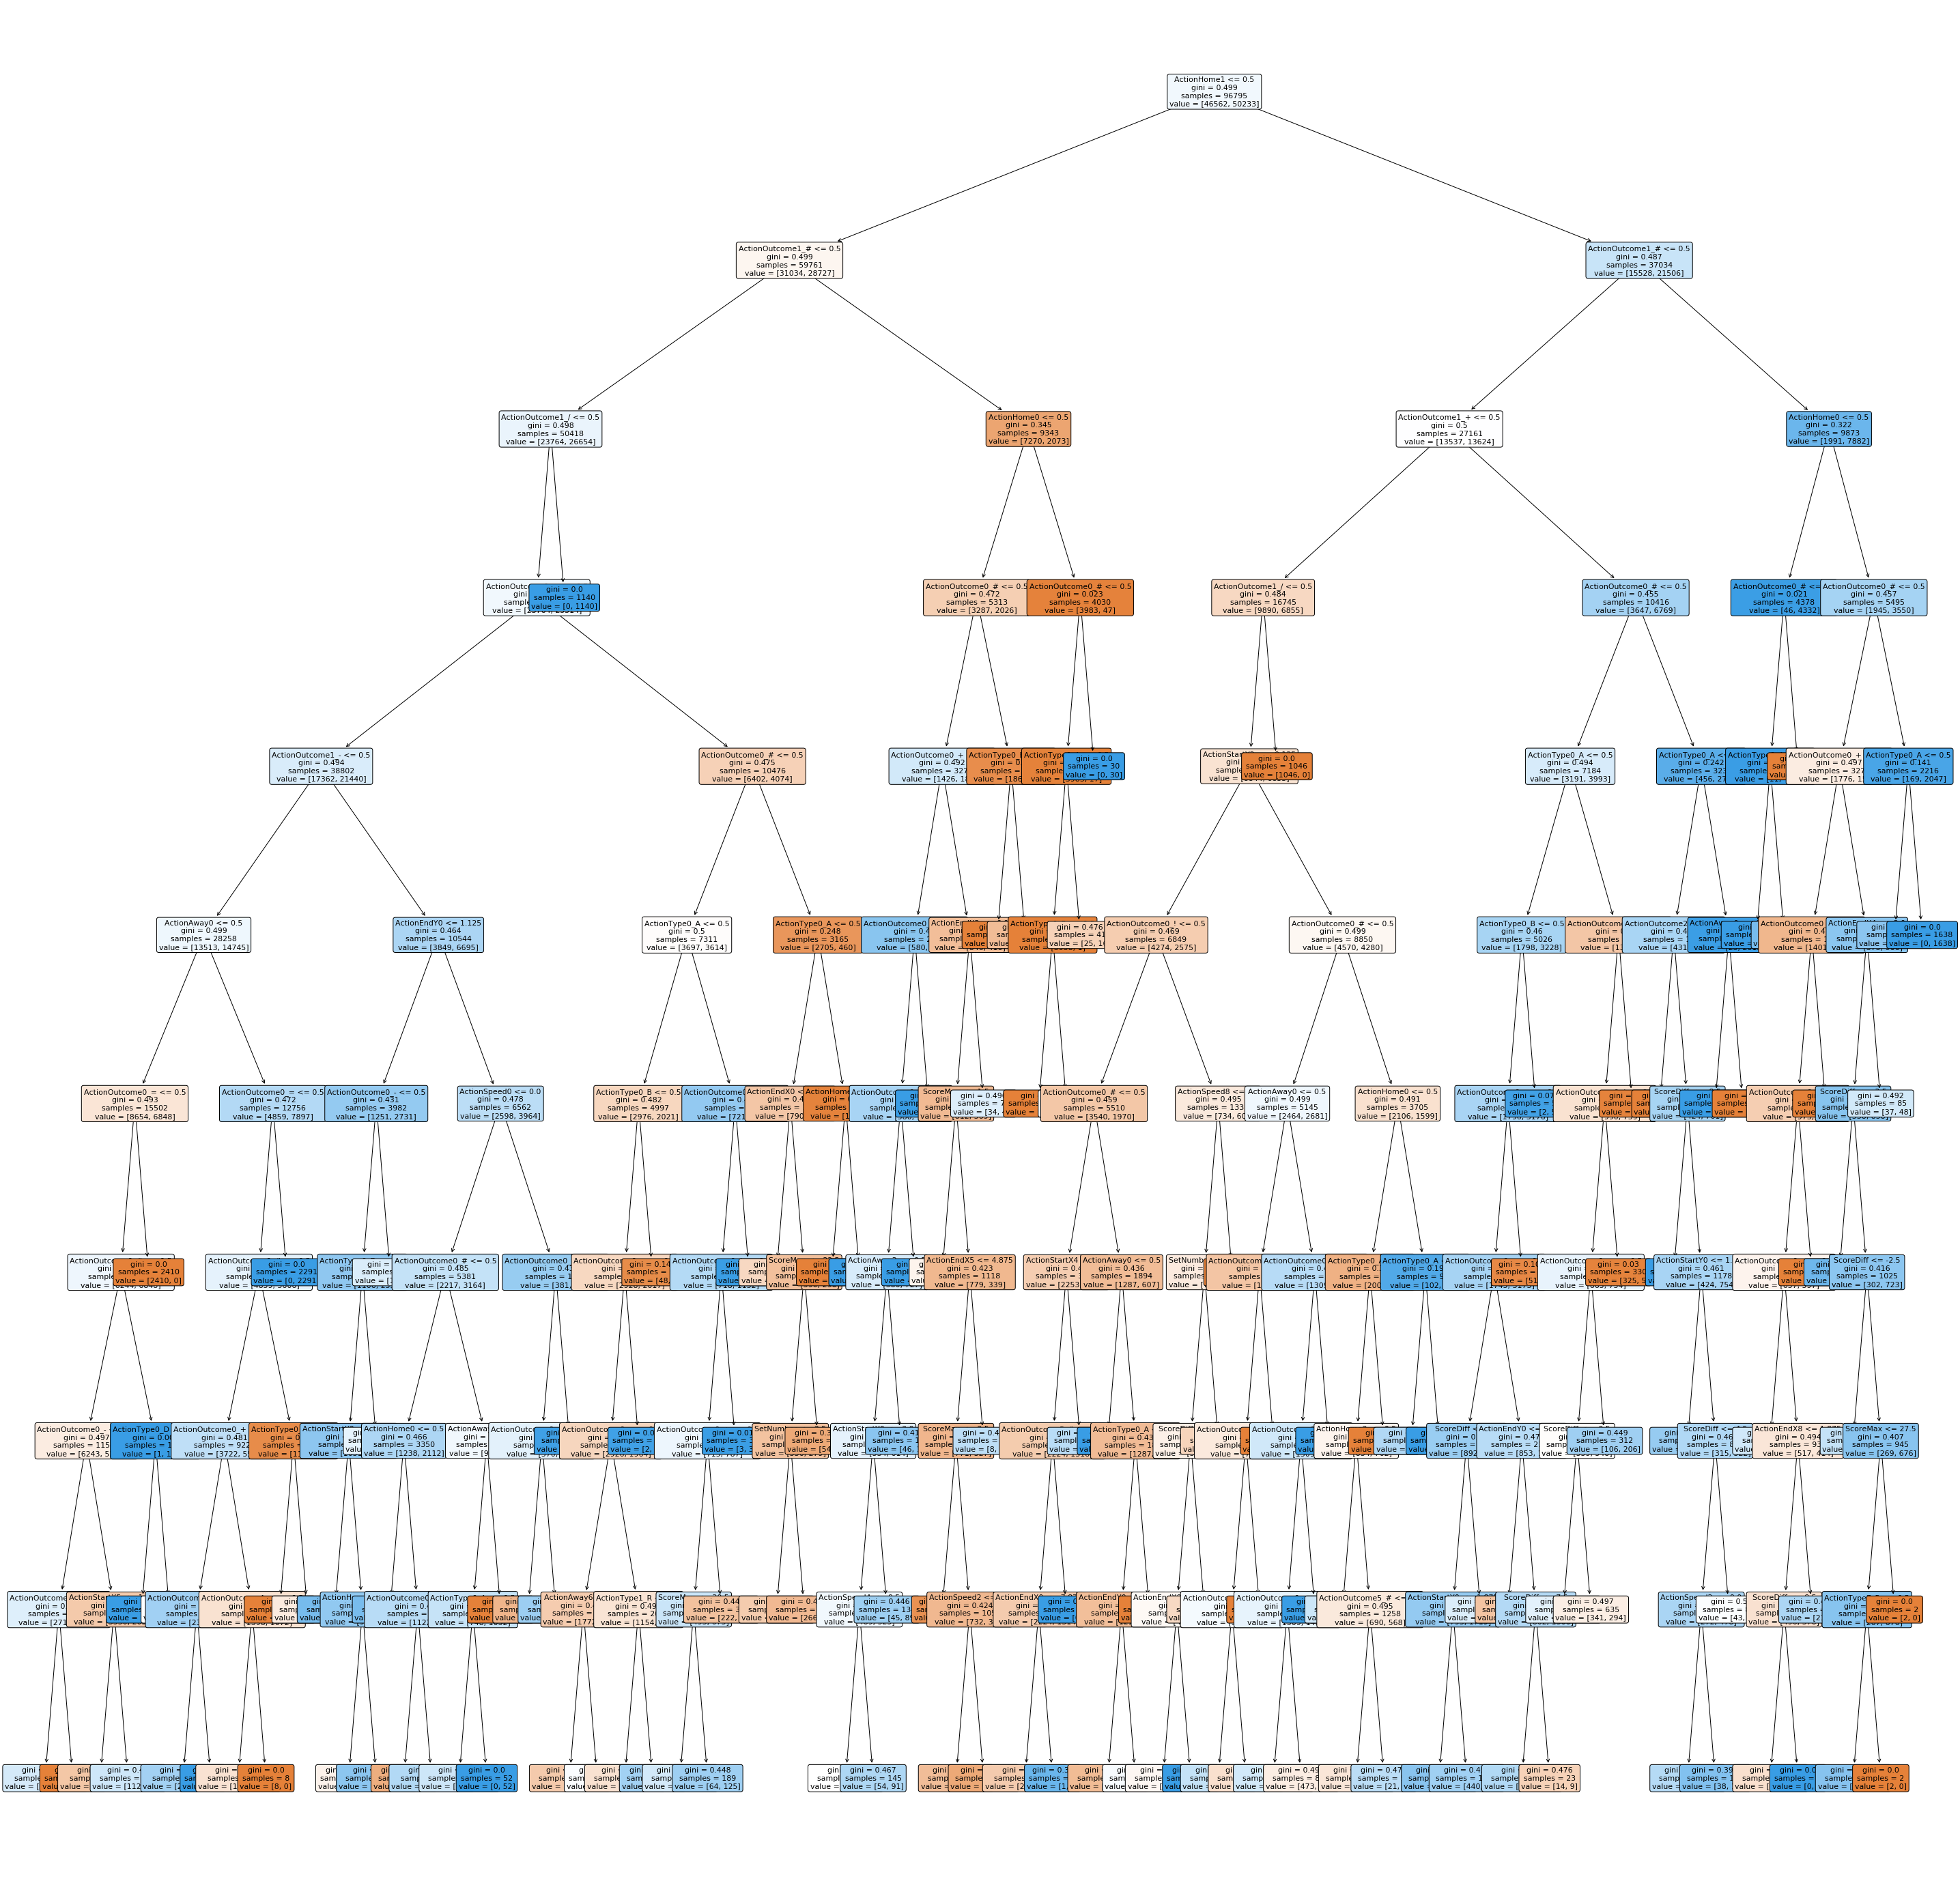

In [22]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

plt.figure(figsize=(50,50))
a = plot_tree(clfn, feature_names=Xn.columns, filled=True, rounded=True, fontsize=11)